This notebook contains all the code required to execute the experiments and generate the figures that are reported in the paper.

In [1]:
import pandas
import matplotlib
import seaborn
import lifelines
import itertools

from scipy.stats import mannwhitneyu
from cliffsDelta import cliffsDelta

%matplotlib inline

In [2]:
FIG_SIZE = (8, 3)
FIG_SIZE_WIDE = (8, 2.5)

ECOSYSTEMS = ['Cargo', 'NPM', 'Packagist', 'Rubygems']
DATE_RANGE = pandas.to_datetime('2013-01-01'), pandas.to_datetime('2020-01-01')
CENSOR_DATE = pandas.to_datetime('2020-01-12')

PALETTE = seaborn.color_palette()
COLORS = {e: PALETTE[i] for i, e in enumerate(ECOSYSTEMS)}
PAL_REL = pandas.np.take(seaborn.color_palette('muted'), [3, 8, 2], axis=0)

SAVEFIG = True

matplotlib.rcParams['figure.figsize'] = FIG_SIZE
matplotlib.rcParams['legend.framealpha'] = 1
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

patch = lambda c, s: matplotlib.lines.Line2D([0], [0], color=c, linestyle=s)

def _savefig(fig, name):
    import os
    fig.savefig(
        os.path.join('..', 'figures', '{}.pdf'.format(name)),
        bbox_inches='tight'
    )
    
savefig = _savefig if SAVEFIG else lambda x, y: None

## Dataset

### Load data

In [3]:
df_releases = dict()
df_dependencies = dict()
df_repositories = dict()

for ecosystem in ECOSYSTEMS:
    print('Loading', ecosystem)
    print('.. releases')
    df_releases[ecosystem] = (
        pandas.read_csv(
            '../data/{}-releases.csv.gz'.format(ecosystem),
            parse_dates=['date'],
            infer_datetime_format=True,
        )
        [lambda d: d['date'] >= pandas.to_datetime('1990-01-01')]
    )
    
    print('.. dependencies')
    df_dependencies[ecosystem] = (
        pandas.read_csv(
            '../data/{}-dependencies.csv.gz'.format(ecosystem),
        )
    )
    print('.. repositories')
    df_repositories[ecosystem] = (
        pandas.read_csv(
            '../data/{}-repositories.csv.gz'.format(ecosystem),
            parse_dates=['date'],
            infer_datetime_format=True,
        )
    )
    
print('Done!')

Loading Cargo
.. releases
.. dependencies
.. repositories
Loading NPM
.. releases
.. dependencies
.. repositories
Loading Packagist
.. releases
.. dependencies
.. repositories
Loading Rubygems
.. releases
.. dependencies
.. repositories
Done!


### Dataset overview

In [4]:
data = pandas.DataFrame(index=['packages', 'releases', 'dependencies', 'first', 'repositories'], columns=ECOSYSTEMS)

for ecosystem in ECOSYSTEMS:
    data.at['packages', ecosystem] = len(df_releases[ecosystem].drop_duplicates(['package']))
    data.at['releases', ecosystem] = len(df_releases[ecosystem].drop_duplicates(['package', 'version']))
    data.at['dependencies', ecosystem] = len(df_dependencies[ecosystem])
    data.at['first', ecosystem] = df_releases[ecosystem]['date'].min()
    data.at['repositories', ecosystem] = len(df_repositories[ecosystem])
    
data

,Cargo,NPM,Packagist,Rubygems
packages,34769,1217677,180093,154997
releases,183061,9383405,1519373,955571
dependencies,795945,48695335,4726905,2396996
first,2014-11-11 00:22:07,2010-11-09 23:36:08,1994-08-23 00:00:00,1999-12-31 13:30:00
repositories,25416,742202,170085,103324


In [5]:
data.T[['packages', 'releases', 'dependencies']].sum()

packages         1587536.0
releases        12041410.0
dependencies    56615181.0
dtype: float64

Our dependency constraint parsers were able to cope with the large majority of dependency constraints. However, some of them could not be parsed. Let's quantify this.
Since the analyses that rely on this preparatory parsing step focus on the latest snapshot of each ecosystem, we only consider this snapshot to quantify this phenomenon.

In [6]:
(
    pandas.concat([
        df_dependencies[ecosystem]
        .sort_values('rank')
        .drop_duplicates('source', keep='last')
        .assign(ecosystem=ecosystem)
        for ecosystem in ECOSYSTEMS], 
        axis=0
    )
    .pivot_table(index='ecosystem', columns=['i_empty'], values='target', aggfunc='count', margins=True)
    .assign(prop=lambda d: d[True] / d['All'])
)

i_empty,False,True,All,prop
ecosystem,,,,
Cargo,24527,1,24528,0.000041
NPM,769985,9827,779812,0.012602
Packagist,122533,4877,127410,0.038278
Rubygems,94249,3353,97602,0.034354
All,1011294,18058,1029352,0.017543


### How many packages and releases?

In [ ]:
fig, axes = matplotlib.pyplot.subplots(nrows=len(ECOSYSTEMS), sharex=True, sharey=False)

fig.set_size_inches((FIG_SIZE[0], FIG_SIZE[1] * len(ECOSYSTEMS)))

data = dict()

for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = axes[i]
    
    data[ecosystem] = (
        df_releases[ecosystem]
        .assign(packages=lambda d: ~d['package'].duplicated())
        .assign(releases=1)
        .groupby(pandas.Grouper(key='date', freq='M'))
        [['packages', 'releases']]
        .sum()
    )
    data[ecosystem].plot(color=2 * [COLORS[ecosystem]], style=['-', '--'], legend=False, ax=ax)
    
    ax.set(
        xlabel='',
        xlim=DATE_RANGE,
        ylabel='new packages and releases',
        title=ecosystem,
    )

savefig(fig, 'overview_pkg_releases')

### How many releases per package?

In [ ]:
_ = pandas.concat([
    df_releases[ecosystem]
    .groupby('package', sort=False, as_index=False)
    .agg({'version': 'count'})
    .assign(ecosystem=ecosystem)
    [['ecosystem', 'package', 'version']]
    for ecosystem in ECOSYSTEMS], axis=0
)

display(
    _
    .assign(version=lambda d: d['version'].where(d['version'] < 5, '5+'))
    .groupby(['ecosystem', 'version'])
    .count()
    .unstack()
    .apply(lambda s: s / s.sum(), axis=1)
)

display(
    _
    .assign(version=lambda d: d['version'].where(d['version'] < 5, '5+'))
    .groupby(['version'])
    .count()
    .apply(lambda s: s / s.sum(), axis=0)
)

How many of them are used by other packages?

In [ ]:
pandas.concat([
    df_releases[ecosystem]
    .groupby('package', sort=False, as_index=False)
    .agg({'rank': 'max'})
    .merge(
        df_dependencies[ecosystem]
        .drop_duplicates(['target'], keep='first')
        .assign(required=True)
        [['target', 'required']],
        how='left',
        left_on='package',
        right_on='target',
    )
    .fillna(0)
    .assign(version=lambda d: d['rank'].where(d['rank'] < 5, '5+'))
    .groupby(['version'], as_index=False)
    .agg({'package': 'count', 'required': 'sum'})
    .assign(prop=lambda d: d['required'] / d['package'])
    .assign(ecosystem=ecosystem)
    [['ecosystem', 'version', 'prop']]
    for ecosystem in ECOSYSTEMS], axis=0
).set_index(['ecosystem', 'version'])

What's the proportion of required packages that have x releases?

In [ ]:
pandas.concat([
    df_releases[ecosystem]
    .groupby('package', sort=False, as_index=False)
    .agg({'rank': 'max'})
    .merge(
        df_dependencies[ecosystem]
        .drop_duplicates(['target'], keep='first')
        [['target']],
        how='right',
        left_on='package',
        right_on='target',
    )
    .assign(version=lambda d: d['rank'].where(d['rank'] < 5, '5+'))
    .groupby(['version'], as_index=False)
    .agg({'package': 'count'})
    .assign(prop=lambda d: d['package'] / d['package'].sum())
    .assign(ecosystem=ecosystem)
    [['ecosystem', 'version', 'prop']]
    for ecosystem in ECOSYSTEMS], axis=0
).set_index(['ecosystem', 'version']).unstack()

Can we observe a different proportion of preone and postone releases for this subset of packages?

In [ ]:
for ecosystem in ECOSYSTEMS: 
    _ = (
        df_releases[ecosystem]
        .assign(preone=lambda d: d['major'] == 0)
        .assign(postone=lambda d: d['major'] > 0)
        .groupby('package', sort=False, as_index=False)
        .agg({'preone': 'sum', 'postone': 'sum', 'version': 'count'})
        .assign(
            only_preone=lambda d: d['postone'] == 0,
            only_postone=lambda d: d['preone'] == 0,
            both=lambda d: (d['postone'] > 0) & (d['preone'] > 0)
        )
        .assign(releases=lambda d: pandas.np.where(d['version'] <= 1, '1', '2+'))
        .groupby('releases', as_index=False)
        [['only_preone', 'only_postone', 'both', 'preone', 'postone', 'version']]
        .sum()
        .assign(ecosystem=ecosystem)
        .eval(
        '''only_preone_prop = only_preone / (only_preone + only_postone + both)
        only_postone_prop = only_postone / (only_preone + only_postone + both)
        both_prop = both / (only_preone + only_postone + both)
        preone_prop = preone / version
        postone_prop = postone / version
        ''')
        [['ecosystem', 'only_preone_prop', 'only_postone_prop', 'both_prop', 'preone_prop', 'postone_prop']]
    )
    display(_)

## How prevalent are 0.y.z?

### Packages in 0.y.z

In [ ]:
fig, ax = matplotlib.pyplot.subplots()

dates = pandas.date_range(*DATE_RANGE, periods=30)
data = dict()

for ecosystem in ECOSYSTEMS:
    data[ecosystem] = []
    
    _ = df_releases[ecosystem]
    for date in reversed(dates):
        _ = _[lambda d: d['date'] <= date]
        
        data[ecosystem].append((
            date, 
            _.package.nunique(),
            len(_.drop_duplicates('package', keep='last')[lambda d: d['major'] == 0]),
        ))
    
    (
        pandas.DataFrame(data[ecosystem], columns=['date', 'packages', 'zero'])
        .set_index('date')
        .sort_index()
        .assign(**{ecosystem: lambda d: d['zero'] / d['packages']})
        [[ecosystem]]
        .plot(ax=ax, color=COLORS[ecosystem])
    )
    
ax.set(
    xlabel='', 
    xlim=DATE_RANGE,
    ylabel='proportion of packages',
    ylim=(0, 1),
)
ax.legend(loc='lower left', ncol=2)
fig.autofmt_xdate(bottom=0.2, rotation=0, ha='center')

savefig(fig, 'prevalence_packages')    

In [ ]:
_ = pandas.concat([
    pandas.DataFrame(data[ecosystem], columns=['date', 'packages', 'zero'])
    .set_index('date')
    .eval('prop = zero / packages')
    .assign(ecosystem=ecosystem)
for ecosystem in ECOSYSTEMS], axis=0)

_.sort_index().iloc[-len(ECOSYSTEMS):]

In [ ]:
_.groupby('ecosystem')['prop'].describe()[['mean', 'std', '50%']]

## Newly created packages

### Proportion of created packages below 1.0.0

In [ ]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()
for ecosystem in ECOSYSTEMS:
    data[ecosystem] = (
        df_releases[ecosystem]
        .drop_duplicates('package', keep='first')
        .assign(dev=lambda d: d['major'] == 0)
        .groupby(pandas.Grouper(key='date', freq='M'))
        .agg({'package': 'count', 'dev': 'sum'})
        .assign(proportion=lambda d: d['dev'] / d['package'])
    )
    
    (
        data[ecosystem]
        ['proportion']
        # Shift to avoid 2020-01-01 in the figure
        .shift()
        .rename(ecosystem)
        .plot(ax=ax, color=COLORS[ecosystem])
    )
    
ax.legend()

ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='proportion of created packages\nbelow 1.0.0',
    ylim=(0, 1),
)

#savefig(fig, 'prevalance_created')

In [ ]:
pandas.concat([
    data[ecosystem]
    .reset_index()
    [lambda d: d['date'].between(*DATE_RANGE)]
    .iloc[-1]
    .rename(ecosystem)
for ecosystem in ECOSYSTEMS], axis=1).loc[['proportion']]

For 2019:

In [ ]:
for ecosystem in ECOSYSTEMS:
    _ = (
        df_releases[ecosystem]
        .drop_duplicates('package', keep='first')
        [lambda d: d['date'] >= pandas.to_datetime('2019')]
        .assign(dev=lambda d: d['major'] == 0)
        .assign(package=1)
        [['package', 'dev']]
        .sum()
    )
    print(ecosystem, _['dev'] / _['package'])

### Packages whose first release is 0.1.0 or 1.0.0

In [ ]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()
for ecosystem in ECOSYSTEMS:
    data[ecosystem] = (
        df_releases[ecosystem]
        .drop_duplicates('package', keep='first')
        .assign(**{
            '1.0.0': lambda d: (d['major'] == 1) & (d['minor'] == 0) & (d['patch'] == 0),
            '0.1.0': lambda d: (d['major'] == 0) & (d['minor'] == 1) & (d['patch'] == 0),
        })
        .groupby(pandas.Grouper(key='date', freq='M'))
        .agg({'package': 'count', '1.0.0': 'sum', '0.1.0': 'sum'})
        .assign(**{
            '1.0.0': lambda d: d['1.0.0'] / d['package'],
            '0.1.0': lambda d: d['0.1.0'] / d['package'],
        })
    )
    
    (
        data[ecosystem]
        [['1.0.0', '0.1.0']]
        # Shift to avoid 2020-01-01 in the figure
        .shift()
        .plot(ax=ax, color=[COLORS[ecosystem]] * 2, style=['-', ':'], legend=False)
    )

legend = ax.legend(
    [patch(COLORS[ecosystem], '-') for ecosystem in ECOSYSTEMS],
    ECOSYSTEMS,
    loc='upper center',
    bbox_to_anchor=(0.11, 1),
)

ax.legend(
    [patch('k', '-'), patch('k', ':')],
    ['1.0.0', '0.1.0'],
    loc='upper center',
    title='released as',
    ncol=2
)

ax.add_artist(legend)

ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='proportion of packages',
    ylim=(0, 1),
)

savefig(fig, 'prevalence_initial')

In [ ]:
pandas.concat([
    data[ecosystem]
    .reset_index()
    [lambda d: d['date'].between(*DATE_RANGE)]
    .iloc[-2]
    .rename(ecosystem)
for ecosystem in ECOSYSTEMS], axis=1).loc[['0.1.0', '1.0.0']].sum()

Focusing on 1.0.0, 0.1.0, 0.0.1 and 0.0.0 in 2019:

In [ ]:
_ = pandas.DataFrame([
    df_releases[ecosystem]
    .drop_duplicates('package', keep='first')
    [lambda d: d['date'].dt.year == 2019]
    .assign(nversion=lambda d: d.apply(
        lambda s: '{:.0f}.{:.0f}.{:.0f}'.format(s.major, s.minor, s.patch), axis=1
    ))
    .assign(**{
        '1.0.0': lambda d: d['nversion'] == '1.0.0',
        '0.1.0': lambda d: d['nversion'] == '0.1.0',
        '0.0.1': lambda d: d['nversion'] == '0.0.1',
        '0.0.0': lambda d: d['nversion'] == '0.0.0',
    })
    .assign(**{
        'other-pre': lambda d: ~d['0.1.0'] & ~d['0.0.1']& ~d['0.0.0'] & (d['major'] == 0),
        'other-post': lambda d: ~d['1.0.0'] & d['major'] > 0,
        'total': 1,
    })
    [['total', '1.0.0', '0.1.0', '0.0.1', '0.0.0', 'other-pre', 'other-post']]
    .sum()
    .rename(ecosystem)
    for ecosystem in ECOSYSTEMS]
)

In [ ]:
(
    _
    .apply(lambda s: s / s['total'], axis=1)
    .style.format('{:.1%}')
)

Specifically for npm, 2013: 

In [ ]:
(
    df_releases['NPM']
    .drop_duplicates('package', keep='first')
    [lambda d: d['date'].dt.year == 2013]
    .assign(nversion=lambda d: d.apply(
        lambda s: '{:.0f}.{:.0f}.{:.0f}'.format(s.major, s.minor, s.patch), axis=1
    ))
    .assign(nversion=lambda d: d['nversion'].where(d['nversion'].isin(versions), 'other'))
    .groupby('nversion')
    .agg({'package': 'count'})
    .apply(lambda s: s / s.sum(), axis=0)
    .style.format('{:.1%}')
)

## Inactive packages

### Proportion of active/inactive packages

Are those 0.y.z abandoned packages? Let's have a look at the proportion of them that were active in 2019.

In [148]:
(
    pandas.concat([
        df_releases[ecosystem]
        .drop_duplicates('package', keep='last')
        .assign(dev=lambda d: d['major'] == 0)
        .assign(active=lambda d: d['date'] >= pandas.to_datetime('2019-01-01'))
        .assign(ecosystem=ecosystem)
        for ecosystem in ECOSYSTEMS], 
        axis=0
    )
    .pivot_table(index=['ecosystem', 'dev'], columns=['active'], values='package', aggfunc='count')
    .assign(prop=lambda d: d[True] / (d[True] + d[False]))
)

active            False    True      prop
ecosystem dev                            
Cargo     False     993    1640  0.622864
          True    14356   17780  0.553274
NPM       False  422940  277904  0.396528
          True   365050  151783  0.293679
Packagist False   84852   45001  0.346553
          True    37043   13197  0.262679
Rubygems  False   30249    7243  0.193188
          True   106019   11486  0.097749

What's the overall proportion of active packages?

In [149]:
(
    pandas.concat([
        df_releases[ecosystem]
        .drop_duplicates('package', keep='last')
        .assign(dev=lambda d: d['major'] == 0)
        .assign(active=lambda d: d['date'] >= pandas.to_datetime('2019-01-01'))
        .assign(ecosystem=ecosystem)
        for ecosystem in ECOSYSTEMS], 
        axis=0
    )
    .pivot_table(index=['ecosystem'], columns=['active'], values='package', aggfunc='count')
    .assign(prop=lambda d: d[True] / (d[True] + d[False]))
)

active,False,True,prop
ecosystem,,,
Cargo,15349,19420,0.558544
NPM,787990,429687,0.352874
Packagist,121895,58198,0.323155
Rubygems,136268,18729,0.120835


And what's the proportion of active packages that are 0.y.z?

In [150]:
_ = (
    pandas.concat([
        df_releases[ecosystem]
        .drop_duplicates('package', keep='last')
        .assign(dev=lambda d: d['major'] == 0)
        .assign(active=lambda d: d['date'] >= pandas.to_datetime('2019-01-01'))
        .assign(ecosystem=ecosystem)
        for ecosystem in ECOSYSTEMS], 
        axis=0
    )
    .pivot_table(index=['ecosystem', 'active'], columns=['dev'], values='package', aggfunc='count')
    .assign(prop=lambda d: d[True] / (d[True] + d[False]))
)

_.xs(True, level='active')

dev,False,True,prop
ecosystem,,,
Cargo,1640,17780,0.915551
NPM,277904,151783,0.353241
Packagist,45001,13197,0.226760
Rubygems,7243,11486,0.613274


Is there a statistical imbalance between the number of preone/postone active/inactive?

In [151]:
from scipy.stats import fisher_exact

for ecosystem in ECOSYSTEMS:
    odds, pvalue = fisher_exact(_.loc[ecosystem].drop(columns=['prop']))
    print('{}: {:.3f} ({:.6f})'.format(ecosystem, odds, pvalue))

Cargo: 0.750 (0.000000)
NPM: 0.633 (0.000000)
Packagist: 0.672 (0.000000)
Rubygems: 0.452 (0.000000)


### Evolution of the proportion of active packages

In [152]:
dates = pandas.date_range(*DATE_RANGE, periods=30)
active = pandas.to_timedelta('365 days')
data = dict()

for ecosystem in ECOSYSTEMS:
    data[ecosystem] = []
    
    _ = df_releases[ecosystem]
    for date in reversed(dates):
        _ = _[lambda d: d['date'] <= date]
        
        temp = _.drop_duplicates('package', keep='last')
        temp_pre = temp.query('major == 0')
        temp_post = temp.query('major > 0')
        
        data[ecosystem].append((
            date, 
            len(temp),
            len(temp_pre),
            len(temp_post),
            len(temp[lambda d: d['date'] >= (date - active)]),
            len(temp_pre[lambda d: d['date'] >= (date - active)]),
            len(temp_post[lambda d: d['date'] >= (date - active)]),
        ))
    
    data[ecosystem] = (
        pandas.DataFrame(data[ecosystem], columns=['date', 'packages', 'pre', 'post', 'active', 'a_pre', 'a_post'])
        .set_index('date')
        .sort_index()
    )

What is the evolution of the proportion of active packages?

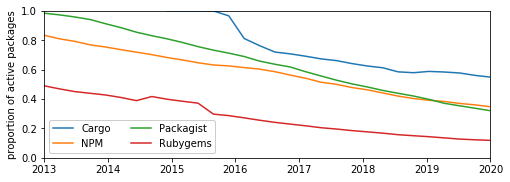

In [153]:
fig, ax = matplotlib.pyplot.subplots()

for ecosystem in ECOSYSTEMS:
    (
        data[ecosystem]
        .assign(**{ecosystem: lambda d: d['active'] / d['packages']})
        [[ecosystem]]
        .plot(ax=ax, color=COLORS[ecosystem])
    )
    
ax.set(
    xlabel='', 
    xlim=DATE_RANGE,
    ylabel='proportion of active packages',
    ylim=(0, 1),
)
ax.legend(loc='lower left', ncol=2)
fig.autofmt_xdate(bottom=0.2, rotation=0, ha='center')

savefig(fig, 'prevalence_packages_active')    

In [154]:
_ = pandas.concat([
    data[ecosystem]
    .eval('active = active / packages')
    .assign(ecosystem=ecosystem)
    [['ecosystem', 'active']]
for ecosystem in ECOSYSTEMS], axis=0)

_.sort_index().iloc[-len(ECOSYSTEMS):]

,ecosystem,active
date,,
2020-01-01,NPM,0.347401
2020-01-01,Cargo,0.549301
2020-01-01,Packagist,0.320470
2020-01-01,Rubygems,0.118707


This figure combines the proportion of preone packages w.r.t. all packages, and the proportion of preone packages w.r.t. active packages.

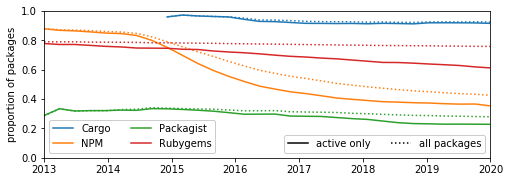

In [160]:
fig, ax = matplotlib.pyplot.subplots()

for ecosystem in ECOSYSTEMS:
    (
        data[ecosystem]
        .assign(**{ecosystem: lambda d: d['a_pre'] / d['active']})
        [[ecosystem]]
        .plot(ax=ax, color=COLORS[ecosystem], style='-')
    )
    
    (
        data[ecosystem]
        .assign(**{'_': lambda d: d['pre'] / d['packages']})
        [['_']]
        .plot(ax=ax, color=COLORS[ecosystem], style=':', legend=None)
    )
    
ax.set(
    xlabel='', 
    xlim=DATE_RANGE,
    ylabel='proportion of packages',
    ylim=(0, 1),
)

legend = ax.legend(loc='lower left', ncol=2)

ax.legend(
    [matplotlib.lines.Line2D([0], [0], color='k'), matplotlib.lines.Line2D([0], [0], color='k', linestyle='dotted')],
    ['active only', 'all packages'],
    loc='lower right', 
    ncol=2,
)
ax.add_artist(legend)

fig.autofmt_xdate(bottom=0.2, rotation=0, ha='center')

savefig(fig, 'prevalence_packages_combined')    

In [156]:
_ = pandas.concat([
    data[ecosystem]
    .eval('preone = pre / packages')
    .eval('preone_active = a_pre / active')
    .assign(ecosystem=ecosystem)
    [['ecosystem', 'preone', 'preone_active']]
for ecosystem in ECOSYSTEMS], axis=0)

_.sort_index().iloc[-len(ECOSYSTEMS):]

,ecosystem,preone,preone_active
date,,,
2020-01-01,NPM,0.425031,0.353366
2020-01-01,Cargo,0.924308,0.915362
2020-01-01,Packagist,0.279523,0.227998
2020-01-01,Rubygems,0.758192,0.611943


### How long for a package to become inactive?

In [ ]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()
for ecosystem in ECOSYSTEMS:
    _ = (
        df_releases[ecosystem]
        .assign(first=lambda d: d['date'], last=lambda d: d['date'])
        .groupby('package', sort=False)
        .agg({'first': 'first', 'last': 'last', 'major': 'last'})
        .assign(dev=lambda d: d['major'] <= 0)
        .assign(observed=lambda d: d['first'] < pandas.to_datetime('2019-01-01'))
        .assign(duration=lambda d: (d['last'].where(d['observed'], CENSOR_DATE) - d['first']) / pandas.to_timedelta('30 day'))
    )

    kmf = lifelines.KaplanMeierFitter()
    
    kmf.fit(_[lambda d: d['dev']].duration, _[lambda d: d['dev']].observed, label=ecosystem)
    kmf.plot(ci_show=False, style='-', ax=ax, c=COLORS[ecosystem])
    
    kmf.fit(_[lambda d: ~d['dev']].duration, _[lambda d: ~d['dev']].observed, label='')
    kmf.plot(ci_show=False, style='--', ax=ax, c=COLORS[ecosystem])
    
    data[ecosystem] = kmf

legend = ax.legend(loc='upper center', ncol=2)
ax.legend(
    [patch('k', '-'), patch('k', '--')],
    ['0.y.z', '>=1.0.0'],
    loc='upper right',
)
ax.add_artist(legend)

ax.set(
    xlim=(0, 60),
    xlabel='duration (in months)',
    ylim=(0, 1),
    ylabel='survival probability'
)

### Monthly proportion of 0.y.z updates

In [ ]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()
for ecosystem in ECOSYSTEMS:
    data[ecosystem] = (
        df_releases[ecosystem]
        .assign(dev=lambda d: d['major'] == 0)
        .groupby([pandas.Grouper(key='date', freq='M'), 'dev'])
        [['version']]
        .count()
        .unstack()['version']
        .assign(total=lambda d: d[True] + d[False])
        .assign(
            zero= lambda d: d[True] / d['total'],
            over= lambda d: d[False] / d['total'],
        )
    )
    
    (
        data[ecosystem]
        ['zero']
        # Shift to avoid 2020-01-01 in the figure
        .shift()
        .rename(ecosystem)
        .plot(ax=ax, color=COLORS[ecosystem])
    )
    
ax.legend()

ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='proportion of releases',
    ylim=(0, 1),
)

savefig(fig, 'prevalence_updates')

In [ ]:
pandas.concat([
    data[ecosystem]
    .reset_index()
    [lambda d: d['date'].between(*DATE_RANGE)]
    .iloc[-1]
    .rename(ecosystem)
for ecosystem in ECOSYSTEMS], axis=1).loc[['zero', 'total']]

### Are postone packages older? 

In [131]:
data = pandas.concat([
    df_releases[ecosystem]
    .assign(when=lambda d: pandas.np.where(d['major'] == 0, '0.y.z', '>=1.0.0'))
    .groupby(['package', 'when'], sort=False)
    .agg(
        first=('date', 'first'),
        last=('date', 'last'),
    )
    .assign(age=lambda d: (d['last'] - d['first']) / pandas.to_timedelta('30 days'))
    [lambda d: d['age'] > 0]
    .reset_index()
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS], axis=0
)

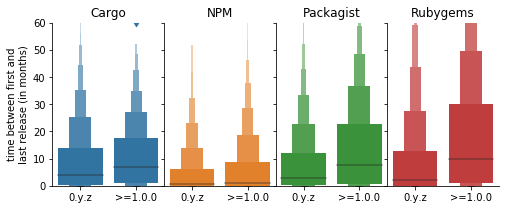

In [132]:
fig, axes = matplotlib.pyplot.subplots(
    ncols=len(ECOSYSTEMS), 
    sharex=False, 
    sharey=True,
    gridspec_kw=dict(wspace=0)
)

for i, ecosystem in enumerate(ECOSYSTEMS):
    seaborn.boxenplot(
        y='age',
        x='when',
        data=data[lambda d: d['ecosystem'] == ecosystem],
        order=['0.y.z', '>=1.0.0'],
        color=COLORS[ecosystem],
        ax=axes[i],
    )
    
    axes[i].set(
        title=ecosystem,
        xlabel='', 
        ylabel=''
    )

seaborn.despine(fig, top=True, right=True)
    
axes[0].set(
    xlabel='',
    ylabel='time between first and\nlast release (in months)',
    ylim=(0, 60),
)

savefig(fig, 'barrier_age')

In [133]:
(
    data
    .groupby(['ecosystem', 'when'])
    ['age']
    .describe()
    [['mean', 'std', '25%', '50%', '75%']]
)

mean        std       25%        50%        75%
ecosystem when                                                         
Cargo     0.y.z     9.658189  12.847144  0.389845   3.994877  13.908534
          >=1.0.0  11.225988  12.511508  0.890595   7.048409  17.751677
NPM       0.y.z     5.309918  10.018753  0.034394   0.774262   6.001082
          >=1.0.0   6.738411  11.304864  0.032285   1.068709   8.868889
Packagist 0.y.z     8.670746  12.872555  0.207341   2.841075  11.926802
          >=1.0.0  14.694516  17.672563  0.785983   7.727437  22.837402
Rubygems  0.y.z    10.362165  17.575476  0.100268   2.040395  12.829946
          >=1.0.0  20.057857  25.140614  0.860304  10.005716  30.132860

In [134]:
for ecosystem in ECOSYSTEMS:
    A = data[lambda d: (d['ecosystem'] == ecosystem) & (d['when'] == '0.y.z')].age
    B = data[lambda d: (d['ecosystem'] == ecosystem) & (d['when'] == '>=1.0.0')].age
    m = mannwhitneyu(A, B)
    d, dl = cliffsDelta(A, B)
    
    print('{:10} 0.y.z vs. >=1.0.0: p={:.5f}; |d|={:.3f} ({})'.format(ecosystem, m.pvalue, d, dl))

Cargo      0.y.z vs. >=1.0.0: p=0.00000; |d|=-0.109 (negligible)
NPM        0.y.z vs. >=1.0.0: p=0.00000; |d|=-0.046 (negligible)
Packagist  0.y.z vs. >=1.0.0: p=0.00000; |d|=-0.209 (small)
Rubygems   0.y.z vs. >=1.0.0: p=0.00000; |d|=-0.270 (small)


Is there any correlation with the number of dependent packages? 

In [135]:
data = (
    data
    .merge(
        pandas.concat([ 
            df_dependencies[ecosystem]
            .drop_duplicates(['source', 'target', 'i_dev'], keep='first')
            .assign(when=lambda d: pandas.np.where(d['i_dev'], '0.y.z', '>=1.0.0'))
            .groupby(['target', 'when'], sort=False, as_index=False)
            .agg({'source': 'count'})
            .assign(ecosystem=ecosystem)
            for ecosystem in ECOSYSTEMS], axis=0
        ),
        how='left',
        left_on=['ecosystem', 'package', 'when'],
        right_on=['ecosystem', 'target', 'when'],
    )
    .fillna({'source': 0})
    [lambda d: d['source'] > 0]
    .assign(ratio=lambda d: d['source'] / d['age'])
)

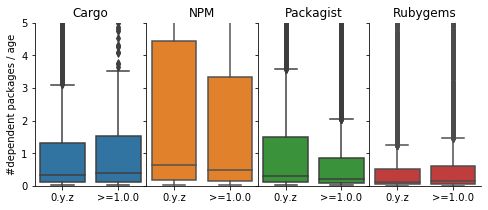

In [136]:
fig, axes = matplotlib.pyplot.subplots(
    ncols=len(ECOSYSTEMS), 
    sharex=False, 
    sharey=True,
    gridspec_kw=dict(wspace=0)
)

for i, ecosystem in enumerate(ECOSYSTEMS):
    seaborn.boxplot(
        y='ratio',
        x='when',
        data=data[lambda d: d['ecosystem'] == ecosystem],
        order=['0.y.z', '>=1.0.0'],
        color=COLORS[ecosystem],
        ax=axes[i],
    )
    
    axes[i].set(
        title=ecosystem,
        xlabel='', 
        ylabel=''
    )

seaborn.despine(fig, top=True, right=True)
    
axes[0].set(
    xlabel='',
    ylabel='#dependent packages / age',
    ylim=(0, 5),
)

savefig(fig, 'barrier_ratio_dependent_age')

In [137]:
(
    data
    .groupby(['ecosystem', 'when'])
    ['ratio']
    .describe()
    [['mean', 'std', '25%', '50%', '75%']]
)

mean            std       25%       50%       75%
ecosystem when                                                             
Cargo     0.y.z     197.293817    3542.588183  0.116583  0.315904  1.312351
          >=1.0.0   210.455000    2098.743236  0.128302  0.384963  1.525345
NPM       0.y.z    2351.713564  299557.751188  0.174636  0.627705  4.442098
          >=1.0.0  1009.732355   27528.598372  0.145651  0.498988  3.347387
Packagist 0.y.z    1975.997004   84049.645222  0.104301  0.303550  1.493430
          >=1.0.0  2889.794580   86885.534218  0.073921  0.206263  0.865171
Rubygems  0.y.z    2776.729304  202025.973995  0.051084  0.130537  0.526877
          >=1.0.0   257.759621    4464.685210  0.053104  0.145011  0.616927

In [138]:
for ecosystem in ECOSYSTEMS:
    A = data[lambda d: (d['ecosystem'] == ecosystem) & (d['when'] == '0.y.z')].ratio
    B = data[lambda d: (d['ecosystem'] == ecosystem) & (d['when'] == '>=1.0.0')].ratio
    m = mannwhitneyu(A, B)
    d, dl = cliffsDelta(A, B)
    
    print('{:10} 0.y.z vs. >=1.0.0: p={:.5f}; |d|={:.3f} ({})'.format(ecosystem, m.pvalue, d, dl))

Cargo      0.y.z vs. >=1.0.0: p=0.01185; |d|=-0.046 (negligible)
NPM        0.y.z vs. >=1.0.0: p=0.00000; |d|=0.055 (negligible)
Packagist  0.y.z vs. >=1.0.0: p=0.00000; |d|=0.123 (negligible)
Rubygems   0.y.z vs. >=1.0.0: p=0.00349; |d|=-0.025 (negligible)


## How long does it take to reach 1.0.0?

a.k.a "The 1.0.0 barrier"

### Packages having reached the 1.0.0 barrier

In [ ]:
df_temp = dict()

for ecosystem in ECOSYSTEMS:
    df_temp[ecosystem] = (
        df_releases[ecosystem]
        .sort_values('rank_date')
        .pipe(lambda df:
            (
                df
                [lambda d: d['major'] == 0]
                .drop_duplicates('package', keep='first')
                [['package', 'rank', 'date']]
                .merge(
                    (
                        df
                        [lambda d: d['major'] > 0]
                        .drop_duplicates('package', keep='first')
                        [['package', 'rank', 'date']]
                    ),
                    how='outer',
                    on='package',
                    suffixes=('_zero', '_nonzero'),
                )
            )
        )
    )

In [ ]:
fig, ax = matplotlib.pyplot.subplots()

data = pandas.concat([
    df_temp[ecosystem]
    .assign(no_zero=lambda d: d['date_zero'].isnull())
    .assign(zero_no_one=lambda d: ~d['date_zero'].isnull() & d['date_nonzero'].isnull())
    .assign(zero_and_one=lambda d: ~d['date_zero'].isnull() & ~d['date_nonzero'].isnull())
    [['no_zero', 'zero_no_one', 'zero_and_one']]
    .sum()
    .rename(ecosystem)
    for ecosystem in ECOSYSTEMS], axis=1
)

_ = data.pipe(lambda s: s / s.sum()).T
_.plot.bar(stacked=True, color=PAL_REL, linewidth=1, edgecolor=(0, 0, 0, 0.3), ax=ax)

positions = [(0.09, 0.5, 0.91), (0.22, 0.68, 0.95), (0.30, 0.75, 0.95), (0.07, 0.52, 0.95)]
for i, ecosystem in enumerate(ECOSYSTEMS):
    for j, kind in enumerate(['no_zero', 'zero_no_one', 'zero_and_one']):
        ax.annotate('{:.1%}'.format(_.at[ecosystem, kind]), (i, positions[i][j]), ha='center', va='center')

ax.set(
    xlabel='',
    ylabel='proportion of packages',
    xlim=(-0.5, 5.2),
    ylim=(0, 1), 
)

seaborn.despine(fig, top=True, right=True)

# TODO: Add a Venn as legend?

ax.legend(
    ax.get_legend_handles_labels()[0][::1],
    ['only >=1.0.0', 'only 0.y.z', 'both'][::1], 
    loc='center right',
    #title='with releases',
)

ax.xaxis.set_tick_params(rotation=0)

savefig(fig, 'barrier_numbers')

In [ ]:
data

### Time to reach 1.0.0

In [ ]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()
for ecosystem in ECOSYSTEMS:
    _ = (
        df_temp[ecosystem]
        .assign(duration=lambda d: (d['date_nonzero'].fillna(CENSOR_DATE) - d['date_zero']) / pandas.to_timedelta('30 day'))
        .assign(observed=lambda d: ~d['date_nonzero'].isnull())
        .assign(duration=lambda d: d['duration'].fillna(0))
    )

    
    kmf = lifelines.KaplanMeierFitter()
    kmf.fit(_.duration, _.observed, label=ecosystem)
    kmf.plot(ci_show=True, ax=ax, c=COLORS[ecosystem])
    data[ecosystem] = kmf

ax.legend(ncol=4, loc='lower center')

ax.set(
    xlim=(0, 60),
    xlabel='duration (in months)',
    ylim=(0, 1),
    ylabel='survival probability'
)

savefig(fig, 'barrier_time_uncensored')

In [ ]:
pandas.concat([
    data[ecosystem]
    .survival_function_at_times([0, 1, 3, 6, 12, 18, 24, 36, 48, 60])
    .rename(ecosystem)
    for ecosystem in ECOSYSTEMS
], axis=1).iloc[:,-len(ECOSYSTEMS):]

Focusing on those having a 0.y.z releases:

In [ ]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()
for ecosystem in ECOSYSTEMS:
    _ = (
        df_temp[ecosystem]
        .dropna(subset=['date_zero'])
        .assign(duration=lambda d: (d['date_nonzero'].fillna(CENSOR_DATE) - d['date_zero']) / pandas.to_timedelta('30 day'))
        .assign(observed=lambda d: ~d['date_nonzero'].isnull())
    )

    
    kmf = lifelines.KaplanMeierFitter()
    kmf.fit(_.duration, _.observed, label=ecosystem)
    kmf.plot(ci_show=False, ax=ax, c=COLORS[ecosystem])
    
    
    kmf_ = lifelines.KaplanMeierFitter()
    kmf_.fit(_[_.observed].duration, label='')
    kmf_.plot(ci_show=False, ax=ax, c=COLORS[ecosystem], style='--')
    data[ecosystem] = (kmf, kmf_)
    
ax.set(
    xlim=(0, 50),
    xlabel='duration (in months)',
    ylim=(0, 1),
    ylabel='survival probability'
)

legend = ax.legend(loc='center')
ax.legend(
    [patch('k', '-'), patch('k', '--')],
    ['all packages', 'having reached >=1.0.0'],
    loc='center right',
)
ax.add_artist(legend)

savefig(fig, 'barrier_time')

In [ ]:
pandas.concat([
    pandas.concat([
        data[ecosystem][i]
        .survival_function_at_times([1, 3, 6, 12, 18, 24, 36, 48, 60])
        .rename(ecosystem)
        for ecosystem in ECOSYSTEMS
    ], axis=1).rename(columns=lambda x: x + '_' + label)
    for i, label in enumerate(['censored', 'uncensored'])
], axis=1).iloc[:,-len(ECOSYSTEMS):].style.format("{:.2%}")

### Updates and time to reach 1.0.0 (observed only)

In [ ]:
fig, axes = matplotlib.pyplot.subplots(ncols=2, sharex=False, sharey=False)

for ecosystem in ECOSYSTEMS:
    for i, kind in enumerate(['time', 'updates']):
        ax = axes[i]
        (
            df_temp[ecosystem]
            # Remove unobserved event
            .dropna()
            .assign(
                time=lambda d: (d['date_nonzero'] - d['date_zero']) / pandas.to_timedelta('30 day'),
                updates=lambda d: d['rank_nonzero'] - d['rank_zero'],
            )
            .groupby(kind)
            .agg({'package': 'count'})
            .apply(lambda s: s.cumsum() / s.sum())
            .rename(columns={'package': ecosystem})
            .plot(ax=ax, color=COLORS[ecosystem], legend=(i==0))
        )
        
axes[0].set(
    xlim=(0, 30),
    xlabel='time (in months)',
    ylim=(0, 1),
    ylabel='proportion of\npackages (cumulative)',
)

axes[1].set(
    xlim=(0, 30),
    xlabel='number of releases',
    ylim=(0, 1),
)

savefig(fig, 'barrier_reaching_combined')

In [ ]:
pandas.concat([
    df_temp[ecosystem]
    .dropna()
    .assign(
        time=lambda d: (d['date_nonzero'] - d['date_zero']) / pandas.to_timedelta('30 day'),
        updates=lambda d: d['rank_nonzero'] - d['rank_zero'],
        ecosystem=ecosystem
    )
    [['ecosystem', 'time', 'updates']]
    for ecosystem in ECOSYSTEMS
]).groupby('ecosystem').describe().T.style.format('{:.2f}')

### Update delay before and after 1.0.0

a.k.a "Major version zero is all about rapid development"

In [ ]:
data = pandas.concat([
    df_releases[ecosystem]
    #[lambda d: d['package'].isin(has_both[ecosystem])]
    .assign(when=lambda d: pandas.np.where(d['major'] == 0, '0.y.z', '>=1.0.0'))
    .groupby(['package', 'when'], sort=False)
    .agg(
        first=('date', 'min'),
        last=('date', 'max'),
        nb=('version', 'count'),
    )
    .reset_index()
    [lambda d: d['nb'] > 1]
    .assign(delay=lambda d: (d['last'] - d['first']) / pandas.to_timedelta('1 day') / d['nb'])
    .assign(ecosystem=ecosystem)
    [['ecosystem', 'package', 'when', 'nb', 'delay']]
    for ecosystem in ECOSYSTEMS],
    axis=0
)

In [ ]:
fig, axes = matplotlib.pyplot.subplots(
    ncols=len(ECOSYSTEMS), 
    sharex=False, 
    sharey=True,
    gridspec_kw=dict(wspace=0)
)

for i, ecosystem in enumerate(ECOSYSTEMS):
    seaborn.boxenplot(
        y='delay',
        x='when',
        data=data[lambda d: d['ecosystem'] == ecosystem],
        order=['0.y.z', '>=1.0.0'],
        color=COLORS[ecosystem],
        ax=axes[i],
    )
    
    axes[i].set(
        title=ecosystem,
        xlabel='', 
        ylabel=''
    )

seaborn.despine(fig, top=True, right=True)
    
axes[0].set(
    xlabel='',
    ylabel='time between releases (in days)',
    ylim=(0, 365),
)

savefig(fig, 'rapid_update_delay')

In [ ]:
(
    data
    .groupby(['ecosystem', 'when'])
    ['delay']
    .describe()
    [['mean', 'std', '25%', '50%', '75%']]
)

Statistical comparisons based on Mann-Whitney U and Cliff's Delta:

In [ ]:
for ecosystem in ECOSYSTEMS:
    A = data[lambda d: (d['ecosystem'] == ecosystem) & (d['when'] == '0.y.z')].delay
    B = data[lambda d: (d['ecosystem'] == ecosystem) & (d['when'] == '>=1.0.0')].delay
    m = mannwhitneyu(A, B)
    d, dl = cliffsDelta(A, B)
    
    print('{:10} before vs. after: p={:.5f}; |d|={:.3f} ({})'.format(ecosystem, m.pvalue, d, dl))

Between package distributions:

In [ ]:
for e1, e2 in itertools.combinations(ECOSYSTEMS, r=2):
    A = data[lambda d: (d['ecosystem'] == e1)].delay
    B = data[lambda d: (d['ecosystem'] == e2)].delay
    m = mannwhitneyu(A, B)
    d, dl = cliffsDelta(A, B)
    
    print('{:6} vs {:6}: p={:.5f}; |d|={:.3f} ({})'.format(e1, e2, m.pvalue, d, dl))

### Do they have more releases?

In [ ]:
fig, axes = matplotlib.pyplot.subplots(
    ncols=len(ECOSYSTEMS), 
    sharex=False, 
    sharey=True,
    gridspec_kw=dict(wspace=0)
)

for i, ecosystem in enumerate(ECOSYSTEMS):
    seaborn.boxenplot(
        y='nb',
        x='when',
        data=data[lambda d: d['ecosystem'] == ecosystem],
        order=['0.y.z', '>=1.0.0'],
        color=COLORS[ecosystem],
        ax=axes[i],
    )
    
    axes[i].set(
        title=ecosystem,
        xlabel='', 
        ylabel=''
    )

seaborn.despine(fig, top=True, right=True)
    
axes[0].set(
    xlabel='',
    ylabel='number of releases',
    ylim=(0, 50),
)

savefig(fig, 'rapid_update_nb')

In [ ]:
(
    data
    .groupby(['ecosystem'])
    ['nb']
    .describe()
    [['mean', 'std', '25%', '50%', '75%']]
)

In [ ]:
for ecosystem in ECOSYSTEMS:
    A = data[lambda d: (d['ecosystem'] == ecosystem) & (d['when'] == '0.y.z')].nb
    B = data[lambda d: (d['ecosystem'] == ecosystem) & (d['when'] == '>=1.0.0')].nb
    m = mannwhitneyu(A, B)
    d, dl = cliffsDelta(A, B)
    
    print('{:10} before vs. after: p={:.5f}; |d|={:.3f} ({})'.format(ecosystem, m.pvalue, d, dl))

### Release frequency for preone and postone, per package

In [ ]:
_ = (
    data
    [lambda d: d['when'] == '0.y.z']
    [['ecosystem', 'package', 'nb', 'delay']]
    .merge(
        data
        [lambda d: d['when'] == '>=1.0.0']
        [['ecosystem', 'package', 'nb', 'delay']],
        how='inner',
        on=['ecosystem', 'package'],
        suffixes=('_pre', '_post')
    )
    # Remove packages without "enough" releases
    #[lambda d: (d['nb_pre'] >= 10) & (d['nb_post'] >= 10)]
    .assign(
        freq_pre=lambda d: 1 / d['delay_pre'],
        freq_post=lambda d: 1 / d['delay_post'],
    )
    .assign(ratio=lambda d: d['freq_post'] / d['freq_pre'])
    .replace({'ratio': {0: pandas.np.nan, pandas.np.inf: pandas.np.nan}})
    .dropna(subset=['ratio'])
)

In [ ]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxplot(
    x='ecosystem',
    y='ratio',
    hue='ecosystem',
    palette=COLORS,
    dodge=False,
    data=_,
    ax=ax,
)

ax.legend().remove()
ax.set(
    xlabel='',
    ylabel='release frequency ratio',
    ylim=(0, 2),
)

ax.hlines(1, -0.5, len(ECOSYSTEMS) - 0.5, alpha=0.2)

savefig(fig, 'rapid_update_ratio')

In [ ]:
(
    _
    .groupby('ecosystem')
    [['ratio']]
    .describe()
)

In [ ]:
(
    _
    .assign(above=lambda d: d['ratio'] >= 1)
    .groupby('ecosystem')
    .agg({'above': 'sum', 'package': 'count'})
    .assign(prop=lambda d: d['above'] / d['package'])
)

## How permissive are pre-1.0.0 dependency constraints?

a.k.a. "Major version zero (0.y.z) is for initial development. Anything MAY change at any time."

### Permissiveness of pre-1.0.0 constraints

Only versions released during a month are considered for this month.
If a package is updated more than once, only its latest release is considered. 

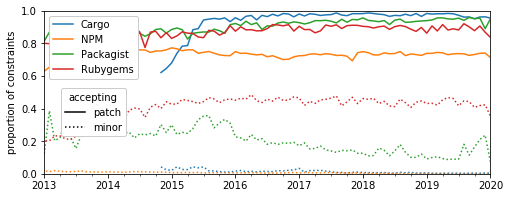

In [31]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()
for ecosystem in ECOSYSTEMS:
    data[ecosystem] = (
        df_dependencies[ecosystem]
        [lambda d: d['i_dev'] == True]
        .merge(
            df_releases[ecosystem][['package', 'date', 'rank']],
            how='inner',
            left_on=['source', 'rank'],
            right_on=['package', 'rank'],
        )
        .groupby(['source', 'target', pandas.Grouper(key='date', freq='M')], as_index=False, sort=False)
        .tail(1)
        .groupby(pandas.Grouper(key='date', freq='M'))
        .agg({
            'source': 'nunique',
            'constraint': 'count',
            'i_minor': 'sum',
            'i_patch': 'sum',
        })
        .eval('minor = i_minor / constraint')
        .eval('patch = i_patch / constraint')
    )
    
    data[ecosystem][['patch', 'minor']].plot(
        color=2 * [COLORS[ecosystem]], 
        style=['-', ':'],
        legend=False,
        ax=ax
    )

legend = ax.legend(
    [patch(COLORS[ecosystem], '-') for ecosystem in ECOSYSTEMS],
    ECOSYSTEMS,
    loc='upper center',
    bbox_to_anchor=(0.11, 1),
)

ax.legend(
    [patch('k', '-'), patch('k', ':')],
    ['patch', 'minor'],
    loc='lower center',
    bbox_to_anchor=(0.11, 0.2),
    title='accepting',
    #ncol=2,
)

ax.add_artist(legend)

ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='proportion of constraints',
    ylim=(0, 1),
)

savefig(fig, 'stable_permissiviness')

In [33]:
_ = pandas.concat([
        data[ecosystem]
        .loc[DATE_RANGE[0]:DATE_RANGE[1]]
        .assign(ecosystem=ecosystem)
        for ecosystem in ECOSYSTEMS
    ], 
    axis=0
)

_.groupby('ecosystem')[['minor', 'patch']].describe().T

ecosystem        Cargo        NPM  Packagist   Rubygems
minor count  62.000000  84.000000  84.000000  84.000000
      mean    0.014127   0.006944   0.203214   0.403309
      std     0.010922   0.004296   0.076210   0.081125
      min     0.001958   0.001167   0.087289   0.201717
      25%     0.005092   0.003203   0.141047   0.406005
      50%     0.010802   0.006164   0.196762   0.435861
      75%     0.019668   0.009927   0.248106   0.454582
      max     0.042996   0.019411   0.385965   0.485503
patch count  62.000000  84.000000  84.000000  84.000000
      mean    0.941697   0.730351   0.907372   0.877212
      std     0.081660   0.023999   0.037593   0.030285
      min     0.621053   0.628813   0.812500   0.774126
      25%     0.953578   0.724258   0.877321   0.862469
      50%     0.969676   0.735185   0.917232   0.881718
      75%     0.979802   0.742007   0.939011   0.902525
      max     0.986587   0.772599   0.959151   0.920314

### Focusing on the latest snapshot

In [ ]:
data = pandas.concat([
    df_dependencies[ecosystem]
    .sort_values('rank')
    .drop_duplicates(['source', 'target'], keep='last')
    .assign(
        n=1,
        # Correct values, as patch superseeded by minor superseeded by major
        patch=lambda d: d['i_patch'] & ~d['i_minor'] & ~d['i_major'],
        minor=lambda d: d['i_minor'] & ~d['i_major'],
        major=lambda d: d['i_major'],
    )
    .pivot_table(index='i_dev', values=['n', 'major', 'minor', 'patch'], aggfunc='sum')
    .apply(lambda s: s / s.n, axis=1)
    .drop(columns=['n'])
    .reset_index()
    .rename(columns={'i_dev': 'kind'})
    .replace({'kind': {True: '0.y.z', False: '>=1.0.0'}})
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS],
    axis=0
).set_index(['ecosystem', 'kind'])

In [ ]:
fig, axes = matplotlib.pyplot.subplots(
    ncols=2, 
    sharex=False, 
    sharey=True,
    gridspec_kw=dict(wspace=0)
)

fig.set_size_inches(FIG_SIZE_WIDE)

for i, kind in enumerate(['0.y.z', '>=1.0.0']):
    (
        data
        .xs(kind, level=1)
        [['patch', 'minor', 'major']]
        .plot.bar(stacked=True, color=PAL_REL[::-1], linewidth=1, edgecolor=(0, 0, 0, 0.3), legend=False, ax=axes[i])
    )
    
    axes[i].set(
        title='target is {}'.format(kind),
        xlabel='', 
        ylabel=''
    )
    axes[i].xaxis.set_tick_params(rotation=0)

positions = [
    ((0.40, 0.90), (0.08, 0.45, 0.88)),
    ((0.40, 0.78), (0.08, 0.45, 0.90)),
    ((0.40, 0.82), (0.05, 0.45, 0.86)),
    ((0.20, 0.65), (0.05, 0.23, 0.65)),
]
for i, ecosystem in enumerate(ECOSYSTEMS):
    for j, kind in enumerate(['0.y.z', '>=1.0.0']):
        for k, release in enumerate(['patch', 'minor', 'major']):
            value = data.loc[ecosystem, kind][release]
            if kind == '0.y.z' and release == 'major':
                continue
            axes[j].annotate('{:.1%}'.format(value), (i + 0.03, positions[i][j][k]), ha='center', va='center')
    
axes[0].legend(
    loc='lower center',
    ncol=3,
    bbox_to_anchor=(1, -0.32),
)

seaborn.despine(fig, top=True, right=True)

axes[0].set(
    xlabel='',
    ylabel='proportion of constraints',
    ylim=(0, 1),
)

savefig(fig, 'stable_snapshot')

In [ ]:
data.T

## To what extent are 0.y.z packages used by other packages?

a.k.a. "If your software is being used in production, it should probably already be 1.0.0. If you have a stable API on which users have come to depend, you should be 1.0.0."

### Number of dependents for required packages above and below 1.0.0

Only the last snapshot of each ecosystem is considered. 

Only packages with at least one reverse dependency are considered.

In [ ]:
data = pandas.concat([
    df_dependencies[ecosystem]
    .sort_values('rank')
    .drop_duplicates('source', keep='last')
    .groupby(['target', 'i_dev'], sort=False, as_index=False)
    [['source']]
    .count()
    .assign(ecosystem=ecosystem)
    .replace({'i_dev': {True: '0.y.z', False: '>=1.0.0'}})
    for ecosystem in ECOSYSTEMS
], axis=0)

In [ ]:
fig, axes = matplotlib.pyplot.subplots(
    ncols=len(ECOSYSTEMS), 
    sharex=False, 
    sharey=True,
    gridspec_kw=dict(wspace=0)
)

for i, ecosystem in enumerate(ECOSYSTEMS):
    seaborn.boxenplot(
        y='source',
        x='i_dev',
        data=data[lambda d: d['ecosystem'] == ecosystem],
        order=['0.y.z', '>=1.0.0'],
        color=COLORS[ecosystem],
        ax=axes[i],
    )
    
    axes[i].set(
        title=ecosystem,
        xlabel='', 
        ylabel=''
    )

seaborn.despine(fig, top=True, right=True)
    
axes[0].set(
    xlabel='',
    ylabel='number of dependents',
    ylim=(1, 25),
)

savefig(fig, 'usage_dependents')

In [ ]:
(
    data
    .groupby(['ecosystem', 'i_dev'])
    [['source']]
    .describe()
    .T
)

In [ ]:
for ecosystem in ECOSYSTEMS:
    A = data[lambda d: (d['ecosystem'] == ecosystem) & (d['i_dev'] == '0.y.z')].source
    B = data[lambda d: (d['ecosystem'] == ecosystem) & (d['i_dev'] == '>=1.0.0')].source
    m = mannwhitneyu(A, B)
    d, dl = cliffsDelta(A, B)
    
    print('{:10} before vs. after: p={:.5f}; |d|={:.3f} ({})'.format(ecosystem, m.pvalue, d, dl))

### Dependencies between 0.y.z and >=1.0.0 packages

Only the latest snapshot is considered. 

In [ ]:
data = pandas.concat([
    df_dependencies[ecosystem]
    [['source', 'target', 'rank', 'i_dev']]
    .merge(
        df_releases[ecosystem].sort_values('rank').drop_duplicates('package', keep='last')[['package', 'major', 'rank']],
        how='inner',
        left_on=['source', 'rank'],
        right_on=['package', 'rank'],
    )
    .drop(columns=['package'])
    .assign(source_kind=lambda d: pandas.np.where(d['major'] < 1.0, '0.y.z', '>=1.0.0'))
    .assign(target_kind=lambda d: pandas.np.where(d['i_dev'], '0.y.z', '>=1.0.0'))
    .assign(ecosystem=ecosystem)
    [['ecosystem', 'source', 'target', 'source_kind', 'target_kind']]
    for ecosystem in ECOSYSTEMS],
    axis=0
)

In [ ]:
pandas.concat([
    data[data['ecosystem'] == ecosystem].pipe(lambda df:
        pandas.crosstab([df.ecosystem, df.source_kind], df.target_kind, normalize='all')
    )
    for ecosystem in ECOSYSTEMS
], axis=0)

### Grouped by (source, target) packages.

In [ ]:
data = pandas.concat([
    df_dependencies[ecosystem]
    [['source', 'target', 'rank', 'i_dev']]
    .merge(
        (
            df_releases[ecosystem]
            .drop_duplicates('package', keep='last')
            .assign(source_pre=lambda d: d['major'] < 1.0)
            [['package', 'rank', 'source_pre']]
        ),
        how='inner',
        left_on=['source', 'rank'],
        right_on=['package', 'rank'],
    )
    #.drop(columns=['package'])
    #.merge(
    #    (
    #        df_releases[ecosystem]
    #        .drop_duplicates('package', keep='last')
    #        .assign(target_pre=lambda d: d['major'] < 1.0)
    #        [['package', 'target_pre']]
    #    ),
    #    how='inner',
    #    left_on=['target'],
    #    right_on=['package'],
    #)
    .assign(target_pre=lambda d: d['i_dev'])
    .drop(columns=['package', 'rank', 'i_dev'])
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS],
    axis=0
)

In [ ]:
ndata = []

for ecosystem in ECOSYSTEMS:
    dependents = (
        data
        [lambda d: d['ecosystem'] == ecosystem]
        .groupby(['source'], sort=False, as_index=False)
        .agg({'source_pre': 'first', 'target_pre': 'max'})
    )
    required = (
        data
        [lambda d: d['ecosystem'] == ecosystem]
        .groupby(['target'], sort=False, as_index=False)
        .agg({'source_pre': 'min', 'target_pre': 'first'})
    )
    
    for source in [True, False]:
        for target in [True, False]:
            sources = len(dependents[lambda d: (d['source_pre'] == source) & (d['target_pre'] == target)])
            targets = len(required[lambda d: (d['source_pre'] == source) & (d['target_pre'] == target)])
            ndata.append((
                ecosystem,
                '0.y.z' if source else '>=1.0.0',
                '0.y.z' if target else '>=1.0.0',
                sources,
                sources / len(dependents),
                targets,
                targets / len(required),
            ))
        
ndata = pandas.DataFrame(columns=['ecosystem', 'source', 'target', 'sources', 'p_sources', 'targets', 'p_targets'], data=ndata)

In [ ]:
(
    ndata
    .pivot_table(index=['ecosystem', 'source'], columns=['target'], values=['p_sources', 'p_targets'], aggfunc='first')
    .style.format('{:.1%}').background_gradient(axis=None)
)

### Are required 0.y.z and >=1.0.0 active?

We report on the proportion of required packages that were active. 

In [84]:
_ = (
    pandas.concat([
        df_releases[ecosystem]
        .drop_duplicates('package', keep='last')
        [lambda d: d['package'].isin(
            df_dependencies[ecosystem]
            .sort_values('rank')
            .drop_duplicates(['source', 'rank'], keep='last')
            ['target']
        )]
        .assign(dev=lambda d: d['major'] == 0)
        .assign(active=lambda d: d['date'] >= pandas.to_datetime('2019-01-01'))
        .assign(ecosystem=ecosystem)
        for ecosystem in ECOSYSTEMS], 
        axis=0
    )
    .pivot_table(index=['ecosystem', 'dev'], columns=['active'], values='package', aggfunc='count')
    .assign(prop=lambda d: d[True] / (d[True] + d[False]))
)

In [85]:
_

active           False   True      prop
ecosystem dev                          
Cargo     False    290    586  0.668950
          True    2550   3782  0.597284
NPM       False  60159  46736  0.437214
          True   46839  19645  0.295485
Packagist False  14945  10700  0.417235
          True    5499   2354  0.299758
Rubygems  False   4851   2191  0.311133
          True    8375   1523  0.153869

Regardless of their version number:

In [86]:
(
    _
    .groupby('ecosystem')
    .sum()
    .assign(prop=lambda d: d[True] / (d[True] + d[False]))
)

active,False,True,prop
ecosystem,,,
Cargo,2840,4368,0.605993
NPM,106998,66381,0.382866
Packagist,20444,13054,0.389695
Rubygems,13226,3714,0.219244


### Dependent packages before and after crossing 1.0.0

In [24]:
for ecosystem in ECOSYSTEMS:
    print(ecosystem)
    display(
        df_dependencies[ecosystem]
        .drop_duplicates(['source', 'target', 'i_dev'], keep='last')
        .assign(preone=lambda d: d['i_dev'], postone=lambda d: ~d['i_dev'])
        .groupby('target', sort=False, as_index=False)
        .agg({'preone': 'sum', 'postone': 'sum'})
        [lambda d: (d['preone'] > 0) & (d['postone'] > 0)]
        .assign(diff=lambda d: d['preone'] - d['postone'])
        .assign(more_preone=lambda d: (d['postone'] < d['preone']).astype(int))
        .describe()
        .T
    )

Cargo


,count,mean,std,min,25%,50%,75%,max
preone,847.0,63.570248,254.588384,1.0,1.0,4.0,20.0,3915.0
postone,847.0,39.035419,276.022605,1.0,1.0,2.0,6.0,5291.0
diff,847.0,24.534829,334.971727,-4651.0,0.0,0.0,10.0,3785.0
more_preone,847.0,0.491145,0.500217,0.0,0.0,0.0,1.0,1.0


NPM


,count,mean,std,min,25%,50%,75%,max
preone,31100.0,20.742926,250.073761,1.0,1.0,2.0,6.0,23644.0
postone,31100.0,68.114502,973.913996,1.0,1.0,2.0,7.0,87459.0
diff,31100.0,-47.371576,961.849452,-87286.0,-2.0,0.0,1.0,23341.0
more_preone,31100.0,0.320450,0.466657,0.0,0.0,0.0,1.0,1.0


Packagist


,count,mean,std,min,25%,50%,75%,max
preone,4548.0,5.213500,16.893811,1.0,1.0,2.0,3.0,422.0
postone,4548.0,9.090150,55.927325,1.0,1.0,2.0,4.0,2155.0
diff,4548.0,-3.876649,54.457687,-2127.0,-1.0,0.0,1.0,392.0
more_preone,4548.0,0.255497,0.436188,0.0,0.0,0.0,1.0,1.0


Rubygems


,count,mean,std,min,25%,50%,75%,max
preone,4892.0,7.458708,63.043916,1.0,1.0,2.0,4.0,2736.0
postone,4892.0,23.062756,191.722128,1.0,1.0,2.0,6.0,9738.0
diff,4892.0,-15.604047,178.464557,-9736.0,-3.0,0.0,0.0,599.0
more_preone,4892.0,0.227923,0.419536,0.0,0.0,0.0,0.0,1.0


## Package characteristics on GitHub

In this section, we'll look at the characteristics of those packages being developed on Github. 

### Packages having an associated repository on GitHub

In [56]:
data = pandas.concat([
    df_repositories[ecosystem]
    .merge(
        (
            df_releases[ecosystem]
            .sort_values('rank')
            .drop_duplicates('package', keep='last')
            .assign(dev=lambda d: d['major'] == 0)
            [['package', 'dev']]
        ),
        how='outer',
        on='package',
    )
    .assign(repo=lambda d: ~d['repository'].isnull())
    .assign(ecosystem=ecosystem)
    [['ecosystem', 'package', 'repo', 'dev']]
    for ecosystem in ECOSYSTEMS], 
    axis=0
)

In [ ]:
(
    data
    .groupby(['ecosystem', 'dev'], sort=False, as_index=False)
    .agg({'repo': 'sum', 'package': 'count'})
    .assign(proportion=lambda d: d['repo'] / d['package'])
    .pivot('ecosystem', 'dev', ['repo', 'package', 'proportion'])
    .assign(overall=lambda d: d['repo'].sum(axis=1) / d['package'].sum(axis=1))
    .style.format('{:.1%}', subset=['proportion', 'overall']).background_gradient(axis=None, subset=['proportion', 'overall'])
)

### Difference between pre-1.0.0 and post-1.0.0

In [143]:
data = pandas.concat([
    df_repositories[ecosystem]
    .merge(
        (
            df_releases[ecosystem]
            .sort_values('rank')
            .drop_duplicates('package', keep='last')
            .assign(dev=lambda d: d['major'] == 0)
            .replace({'dev': {True: '0.y.z', False: '>=1.0.0'}})
            [['package', 'rank', 'dev']]
        ),
        how='left',
        on='package',
    )
    .assign(duration=lambda d: (CENSOR_DATE - d['date']) / pandas.to_timedelta('30 day'))
    .assign(releases=lambda d: d['rank'])
    .assign(size=lambda d: d['size'] / 1024)
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS], 
    axis=0
)

In [147]:
data.shape

(1041027, 15)

In [66]:
characteristics = ['stars', 'forks', 'contributors', 'dependent_projects', 'issues', 'size',]
# Other characteristics: watchers, duration

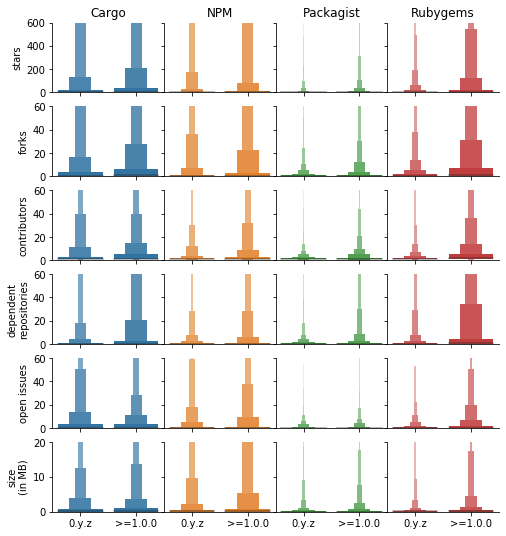

In [67]:
fig, axes = matplotlib.pyplot.subplots(
    ncols=len(ECOSYSTEMS), 
    nrows=len(characteristics),
    sharex=True, 
    sharey='row',
    gridspec_kw=dict(wspace=0)
)

fig.set_size_inches((FIG_SIZE[0], FIG_SIZE[1] * len(characteristics) / 2))

for j, characteristic in enumerate(characteristics):
    for i, ecosystem in enumerate(ECOSYSTEMS):
        seaborn.boxenplot(
            y=characteristic,
            x='dev',
            data=data[lambda d: d['ecosystem'] == ecosystem],
            order=['0.y.z', '>=1.0.0'],
            color=COLORS[ecosystem],
            ax=axes[j][i],
        )
        
        axes[j][i].set(
            title=ecosystem if j == 0 else '',
            xlabel='', 
            ylabel='',
        )
    
seaborn.despine(fig, top=True, right=True)

axes[0][0].set(ylabel='stars', ylim=(0, 600))
axes[1][0].set(ylabel='forks', ylim=(0, 60))
axes[2][0].set(ylabel='contributors', ylim=(0, 60))
axes[3][0].set(ylabel='dependent\nrepositories', ylim=(0, 60))
axes[4][0].set(ylabel='open issues', ylim=(0, 60))
axes[5][0].set(ylabel='size\n(in MB)', ylim=(0, 20))
# axes[6][0].set(ylabel='age\n(in months)', ylim=(0, 120))

savefig(fig, 'char_distributions')

In [68]:
(
    data
    .groupby(['ecosystem', 'dev'])
    [characteristics]
    .describe()
    .loc[:,(slice(None), ['mean', '50%'])]
    .style.format('{:.1f}')
)

In [69]:
temp = []

for ecosystem in ECOSYSTEMS:
    for characteristic in characteristics:
        A = data[lambda d: (d['ecosystem'] == ecosystem) & (d['dev'] == '0.y.z')][characteristic]
        B = data[lambda d: (d['ecosystem'] == ecosystem) & (d['dev'] == '>=1.0.0')][characteristic]
        m = mannwhitneyu(A, B)
        d, dl = cliffsDelta(A, B)
        temp.append((ecosystem, characteristic, m.pvalue, d, dl))
        print('{:10} - {:20} p={:.5f}; d={:.3f} ({})'.format(ecosystem, characteristic, m.pvalue, d, dl))
    print()

Cargo      - stars                p=0.00000; d=-0.117 (negligible)
Cargo      - forks                p=0.00000; d=-0.096 (negligible)
Cargo      - contributors         p=0.00000; d=-0.102 (negligible)
Cargo      - dependent_projects   p=0.00000; d=-0.132 (negligible)
Cargo      - issues               p=0.47119; d=-0.001 (negligible)
Cargo      - size                 p=0.00001; d=-0.056 (negligible)

NPM        - stars                p=0.00000; d=-0.063 (negligible)
NPM        - forks                p=0.00000; d=-0.061 (negligible)
NPM        - contributors         p=0.00000; d=-0.069 (negligible)
NPM        - dependent_projects   p=0.00000; d=-0.038 (negligible)
NPM        - issues               p=0.00000; d=-0.029 (negligible)
NPM        - size                 p=0.00002; d=-0.006 (negligible)

Packagist  - stars                p=0.00000; d=-0.049 (negligible)
Packagist  - forks                p=0.00000; d=-0.068 (negligible)
Packagist  - contributors         p=0.00000; d=-0.068 (negli

In [70]:
for characteristic in characteristics:
    for e1, e2 in itertools.combinations(ECOSYSTEMS, r=2):
    
        A = data[lambda d: (d['ecosystem'] == e1)][characteristic]
        B = data[lambda d: (d['ecosystem'] == e2)][characteristic]
        m = mannwhitneyu(A, B)
        d, dl = cliffsDelta(A, B)
        print('{:20} - {:10} vs {:10} -  p={:.5f}; d={:.3f} ({})'.format(characteristic, e1, e2, m.pvalue, d, dl))
    print()

stars                - Cargo      vs NPM        -  p=0.00000; d=0.162 (small)
stars                - Cargo      vs Packagist  -  p=0.00000; d=0.317 (small)
stars                - Cargo      vs Rubygems   -  p=0.00000; d=0.085 (negligible)
stars                - NPM        vs Packagist  -  p=0.00000; d=0.145 (negligible)
stars                - NPM        vs Rubygems   -  p=0.00000; d=-0.099 (negligible)
stars                - Packagist  vs Rubygems   -  p=0.00000; d=-0.265 (small)

forks                - Cargo      vs NPM        -  p=0.00000; d=0.099 (negligible)
forks                - Cargo      vs Packagist  -  p=0.00000; d=0.197 (small)
forks                - Cargo      vs Rubygems   -  p=0.00000; d=0.056 (negligible)
forks                - NPM        vs Packagist  -  p=0.00000; d=0.088 (negligible)
forks                - NPM        vs Rubygems   -  p=0.00000; d=-0.050 (negligible)
forks                - Packagist  vs Rubygems   -  p=0.00000; d=-0.147 (small)

contributors         - 